Simule una serie ARIMA(1,1,0) con Drfit de tamaño T =
300 y ϕ = 0.5. Ajuste un modelo ARIMA con drift y un modelo AR(1) con
una tendencia determinística(Es decir debe crear dos covariables o variables
regresoras y añadirlas al modelo). Compare los criterios de información para
los dos modelo. Haga Rolling para ver que modelo hace mejores pronósticos,
usando como conjunto de entrenamiento T = 200 para las predicciones 1 y
2 pasos adelante.
Repita el ejercicio anterior, pero ahora simule los datos de un modelo AR(1)
con tendencia determinística.
Repita la experiencia anterior 500 veces y almacene los errores cuadráticos
medios encontrados con el Rolling. Qué conclusión puede dar de los resulta-
dos de simulación?


Criterios de información para datos ARIMA:
ARIMA AIC: 843.0107767482793
AR AIC: 897.3181867153427

MSE para datos ARIMA:
ARIMA MSE: 2.3164764566448857
AR MSE: 2.738512645986699

Criterios de información para datos AR:
ARIMA AIC: 915.2754666743151
AR AIC: 843.24339184012

MSE para datos AR:
ARIMA MSE: 1.7209962804984482
AR MSE: 1.2885695789708564


Simulaciones: 100%|██████████| 5/5 [01:08<00:00, 13.76s/it]



Resultados de 5 simulaciones:
Para datos ARIMA:
Media MSE ARIMA: 2.3164764566448857
Media MSE AR: 2.738512645986699

Para datos AR:
Media MSE ARIMA: 1.7209962804984482
Media MSE AR: 1.2885695789708564


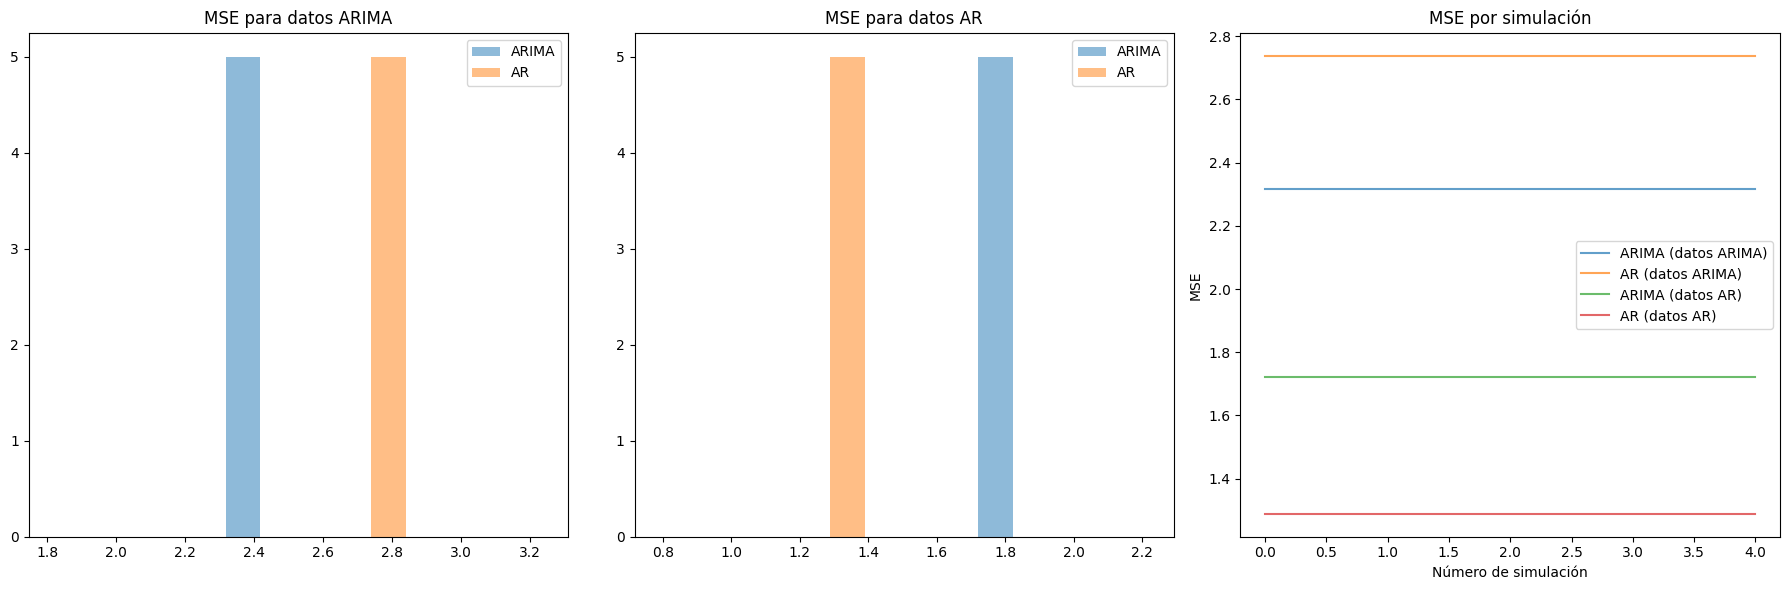

In [5]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm

def simular_arima(T, phi, drift):
    np.random.seed(42)
    e = np.random.normal(0, 1, T)
    y = np.zeros(T)
    y[0] = e[0]
    for t in range(1, T):
        y[t] = drift + y[t-1] + phi * (y[t-1] - y[t-2]) + e[t]
    return y

def simular_ar_tendencia(T, phi, beta):
    np.random.seed(42)
    e = np.random.normal(0, 1, T)
    y = np.zeros(T)
    for t in range(1, T):
        y[t] = beta * t + phi * y[t-1] + e[t]
    return y

def ajustar_modelos(y):
    modelo_arima = ARIMA(y, order=(1,1,0), trend='t').fit()
    
    X = np.column_stack((np.arange(len(y)), np.ones(len(y))))
    modelo_ar = AutoReg(y, lags=1, trend='n', exog=X).fit()
    
    return modelo_arima, modelo_ar

def rolling_forecast(y, train_size, steps):
    errors_arima = []
    errors_ar = []
    
    for i in range(train_size, len(y) - steps + 1):
        train = y[:i]
        test = y[i:i+steps]
        
        modelo_arima, modelo_ar = ajustar_modelos(train)
        
        forecast_arima = modelo_arima.forecast(steps)
        forecast_ar = modelo_ar.forecast(steps, exog=np.column_stack((np.arange(i, i+steps), np.ones(steps))))
        
        errors_arima.append(mean_squared_error(test, forecast_arima))
        errors_ar.append(mean_squared_error(test, forecast_ar))
    
    return np.mean(errors_arima), np.mean(errors_ar)

# Parámetros
T = 300
train_size = 200
phi = 0.5
drift = 0.1
beta = 0.1
n_simulations = 5

# Parte 1 y 2: Simulación y ajuste para un conjunto de datos
y_arima = simular_arima(T, phi, drift)
y_ar = simular_ar_tendencia(T, phi, beta)

for data, data_type in [(y_arima, "ARIMA"), (y_ar, "AR")]:
    modelo_arima, modelo_ar = ajustar_modelos(data)
    print(f"\nCriterios de información para datos {data_type}:")
    print("ARIMA AIC:", modelo_arima.aic)
    print("AR AIC:", modelo_ar.aic)

    mse_arima, mse_ar = rolling_forecast(data, train_size, 2)
    print(f"\nMSE para datos {data_type}:")
    print("ARIMA MSE:", mse_arima)
    print("AR MSE:", mse_ar)

# Parte 3: Repetir n_simulations veces con barra de progreso
mse_arima_list_arima_data = []
mse_ar_list_arima_data = []
mse_arima_list_ar_data = []
mse_ar_list_ar_data = []

for _ in tqdm(range(n_simulations), desc="Simulaciones"):
    y_arima = simular_arima(T, phi, drift)
    mse_arima, mse_ar = rolling_forecast(y_arima, train_size, 2)
    mse_arima_list_arima_data.append(mse_arima)
    mse_ar_list_arima_data.append(mse_ar)
    
    y_ar = simular_ar_tendencia(T, phi, beta)
    mse_arima, mse_ar = rolling_forecast(y_ar, train_size, 2)
    mse_arima_list_ar_data.append(mse_arima)
    mse_ar_list_ar_data.append(mse_ar)

print(f"\nResultados de {n_simulations} simulaciones:")
print("Para datos ARIMA:")
print("Media MSE ARIMA:", np.mean(mse_arima_list_arima_data))
print("Media MSE AR:", np.mean(mse_ar_list_arima_data))
print("\nPara datos AR:")
print("Media MSE ARIMA:", np.mean(mse_arima_list_ar_data))
print("Media MSE AR:", np.mean(mse_ar_list_ar_data))

# Visualización
plt.figure(figsize=(18, 6))

# Histogramas
plt.subplot(1, 3, 1)
plt.hist(mse_arima_list_arima_data, alpha=0.5, label='ARIMA')
plt.hist(mse_ar_list_arima_data, alpha=0.5, label='AR')
plt.title('MSE para datos ARIMA')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(mse_arima_list_ar_data, alpha=0.5, label='ARIMA')
plt.hist(mse_ar_list_ar_data, alpha=0.5, label='AR')
plt.title('MSE para datos AR')
plt.legend()

# Nueva gráfica: MSE por simulación
plt.subplot(1, 3, 3)
plt.plot(range(n_simulations), mse_arima_list_arima_data, label='ARIMA (datos ARIMA)', alpha=0.7)
plt.plot(range(n_simulations), mse_ar_list_arima_data, label='AR (datos ARIMA)', alpha=0.7)
plt.plot(range(n_simulations), mse_arima_list_ar_data, label='ARIMA (datos AR)', alpha=0.7)
plt.plot(range(n_simulations), mse_ar_list_ar_data, label='AR (datos AR)', alpha=0.7)
plt.title('MSE por simulación')
plt.xlabel('Número de simulación')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()